### Mission 2 : Modélisation et tracking des expériences
- **Objectif** : Construire un modèle de régression et suivre les expériences avec MLflow.
- **Tâches** :
  1. Créer un modèle de régression linéaire comme baseline.
  2. Utiliser des modèles avancés comme Random Forest ou Gradient Boosting.
  3. Mettre en place MLflow pour suivre les expériences (métriques comme RMSE, MAE, R²).
  4. Enregistrer le meilleur modèle dans le *Model Registry* de MLflow.

---

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow
import mlflow.sklearn

# Load the cleaned dataset
df = pd.read_csv("data/cleaned_california_housing.csv")

# Split the dataset
X = df.drop(columns="MedHouseVal")
y = df["MedHouseVal"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data size: {X_train.shape}")
print(f"Testing data size: {X_test.shape}")


Training data size: (13049, 8)
Testing data size: (3263, 8)


In [2]:
from mlflow.models import infer_signature
from sklearn.ensemble import GradientBoostingRegressor

mlflow.end_run()

mlflow.set_experiment("california_housing")


def evaluate_and_log_model(model, model_name, params):
    with mlflow.start_run(run_name=f"Run_{model_name}"):
        # Log model parameters
        mlflow.log_params(params)

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Log parameters and metrics
        mlflow.log_param("model_name", model_name)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)

        # Log the model with signature
        signature = infer_signature(X_test, y_pred)
        mlflow.sklearn.log_model(model, model_name, signature=signature, input_example=X_test.head())

        # Add a tag to the run
        mlflow.set_tag("model_type", model_name)

        print(f"Model: {model_name}\n  RMSE: {rmse}\n  MAE: {mae}\n  R2: {r2}\n")

# Baseline: Linear Regression
lr_params = {"fit_intercept": True}
lr_model = LinearRegression(**lr_params)
evaluate_and_log_model(lr_model, "LinearRegression", lr_params)

# Advanced Model: Random Forest
rf_params = {"n_estimators": 400, "max_depth": None, "random_state": 42}
rf_model = RandomForestRegressor(**rf_params)
evaluate_and_log_model(rf_model, "RandomForest", rf_params)

# Advanced Model: Gradient Boosting
gb_params = {"n_estimators": 400, "learning_rate": 0.1, "max_depth": 3, "random_state": 42}
gb_model = GradientBoostingRegressor(**gb_params)
evaluate_and_log_model(gb_model, "GradientBoosting", gb_params)

2025/01/17 20:28:00 INFO mlflow.tracking.fluent: Experiment with name 'california_housing' does not exist. Creating a new experiment.


Model: LinearRegression
  RMSE: 0.5626031257062546
  MAE: 0.4235527429735981
  R2: 0.6378964374821559

Model: RandomForest
  RMSE: 0.42001210947416695
  MAE: 0.28819717859331895
  R2: 0.7981856052027696

Model: GradientBoosting
  RMSE: 0.40632390755554015
  MAE: 0.2814835089231425
  R2: 0.8111255255117784



In [3]:
# Register the best model manually for now
best_model = gb_model
best_model_name = "BestModel"
with mlflow.start_run(run_name=f"Register_{best_model_name}"):
    signature = infer_signature(X_test, best_model.predict(X_test))
    model_uri = mlflow.sklearn.log_model(best_model, best_model_name, signature=signature, input_example=X_test.head(), registered_model_name=best_model_name)
    print(f"Model {best_model_name} registered successfully.")


Model BestModel registered successfully.


Successfully registered model 'BestModel'.
Created version '1' of model 'BestModel'.


### Mission 3 : Analyse des features
- **Objectif** : Comprendre l’impact des variables sur les prédictions.
- **Tâches** :
  1. Calculer les importances globales des features (à l’aide de SHAP ou des features importances).
  2. Analyser l’impact local pour des exemples individuels (à l’aide de SHAP).
  3. Documenter vos conclusions.

---

c:\Studies\IS5\MLOPS\mlops3\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


Lime explanation for example 0:



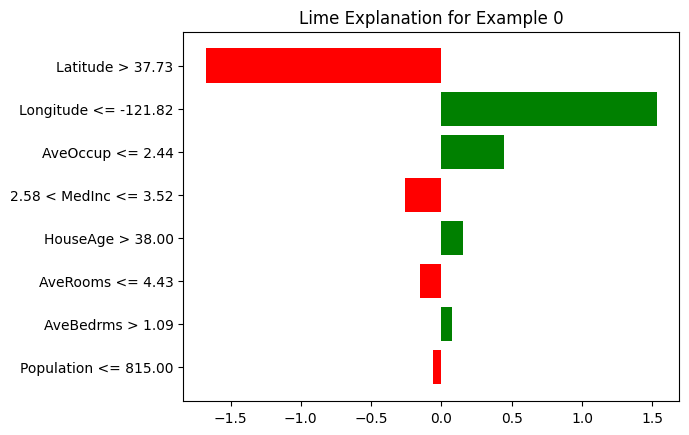

Lime explanation for example 1:



c:\Studies\IS5\MLOPS\mlops3\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


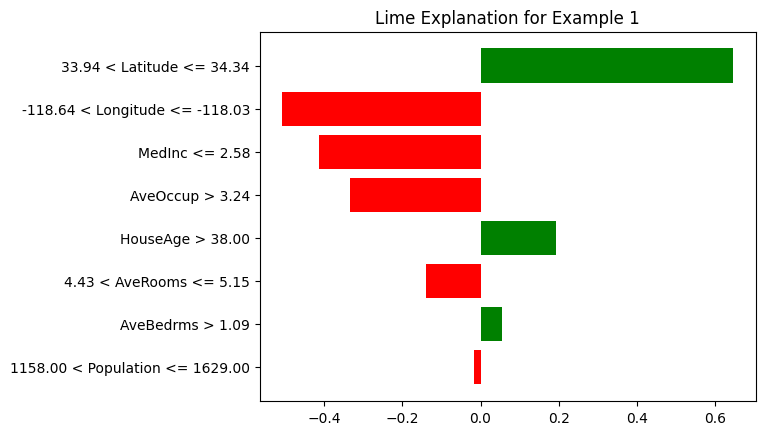

c:\Studies\IS5\MLOPS\mlops3\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


Lime explanation for example 2:



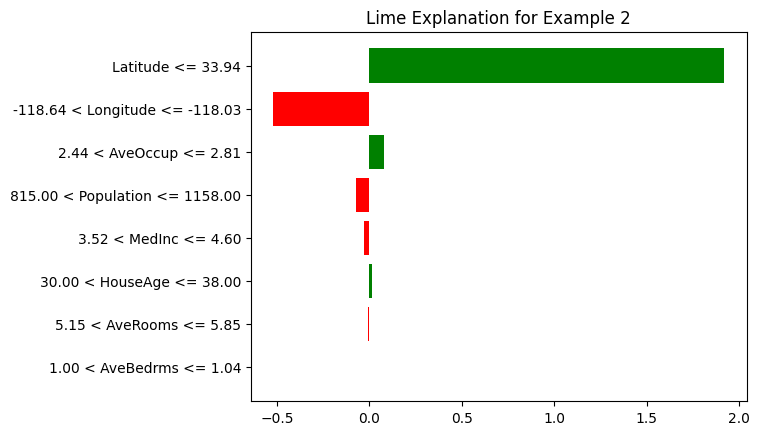

In [9]:
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

# Lime Feature Importance Analysis
def lime_feature_analysis(model, X_train, X_test, feature_names, model_name):
    """Perform feature importance analysis using Lime."""
    explainer = LimeTabularExplainer(
        training_data=X_train.values,
        feature_names=feature_names,
        class_names=["Prediction"],
        mode="regression"
    )
    
    for i in range(3):  # Analyze the first 3 examples
        explanation = explainer.explain_instance(
            data_row=X_test.iloc[i].values,
            predict_fn=model.predict
        )
        print(f"Lime explanation for example {i}:\n")
        explanation.show_in_notebook(show_table=True)
        explanation.as_pyplot_figure()
        plt.title(f"Lime Explanation for Example {i}")
        plt.show()

# Perform feature importance analysis for the best model
lime_feature_analysis(
    model=gb_model, 
    X_train=X_train, 
    X_test=X_test, 
    feature_names=X_train.columns.tolist(), 
    model_name="GradientBoosting"
)


Global Feature Importance:
       Feature  Importance
0      MedInc    0.464314
7   Longitude    0.175745
6    Latitude    0.152244
5    AveOccup    0.123138
2    AveRooms    0.036590
1    HouseAge    0.032287
4  Population    0.008960
3   AveBedrms    0.006721


c:\Studies\IS5\MLOPS\mlops3\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


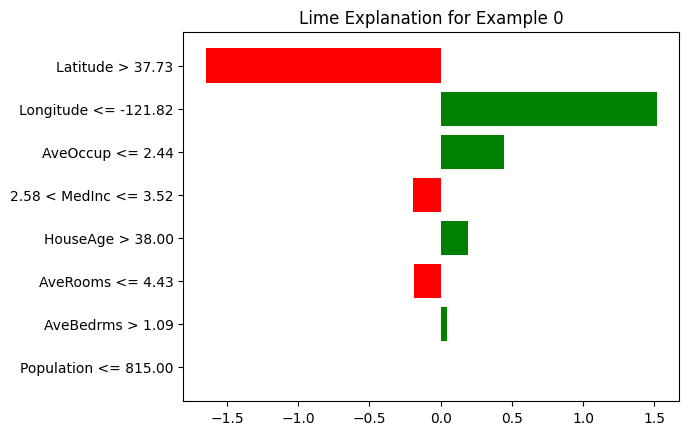

c:\Studies\IS5\MLOPS\mlops3\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


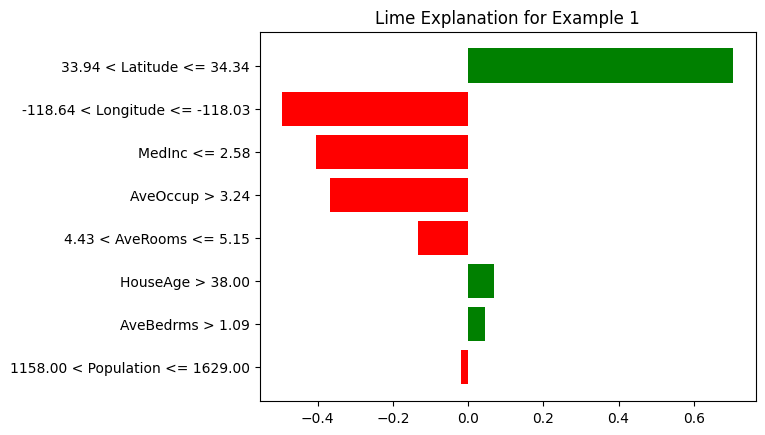

c:\Studies\IS5\MLOPS\mlops3\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


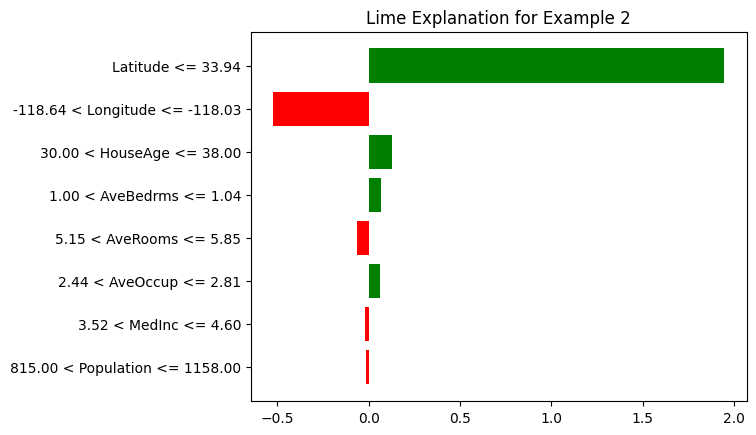

Feature analysis report saved to reports/feature_analysis.json


In [10]:
import pandas as pd
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import json

# Document Feature Importance
def document_feature_importance(global_importances, lime_explanations, output_path="reports/feature_analysis.json"):
    """Document feature importance analyses to a JSON report."""
    report = {
        "global_importance": global_importances,
        "local_explanations": lime_explanations,
    }
    with open(output_path, "w") as f:
        json.dump(report, f, indent=4)
    print(f"Feature analysis report saved to {output_path}")

# Global Feature Importance
def generate_global_importance(model, feature_names):
    """Generate global feature importance if supported by the model."""
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
        importance_df.sort_values(by="Importance", ascending=False, inplace=True)
        print("Global Feature Importance:\n", importance_df)
        return importance_df.to_dict("records")
    else:
        print("Model does not support global feature importance.")
        return []

# Lime Feature Analysis
def lime_feature_analysis(model, X_train, X_test, feature_names):
    """Perform Lime-based feature importance analysis for local explanations."""
    explainer = LimeTabularExplainer(
        training_data=X_train.values,
        feature_names=feature_names,
        class_names=["Prediction"],
        mode="regression"
    )
    explanations = []
    for i in range(3):  # Analyze the first 3 examples
        explanation = explainer.explain_instance(
            data_row=X_test.iloc[i].values,
            predict_fn=model.predict
        )
        explanations.append({
            "example_index": i,
            "local_explanation": explanation.as_list(),
        })
        explanation.as_pyplot_figure()
        plt.title(f"Lime Explanation for Example {i}")
        plt.show()
    return explanations

# Extract variables from the notebook
# Using `gb_model`, `X_train`, `X_test`, and feature names from the notebook
global_importances = generate_global_importance(gb_model, X_train.columns.tolist())
lime_explanations = lime_feature_analysis(gb_model, X_train, X_test, X_train.columns.tolist())
document_feature_importance(global_importances, lime_explanations)
